# Predicting Security wait times using Regression techniques.

## Data preparation 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#Read in csv from github.
SD = pd.read_csv("https://raw.githubusercontent.com/mjholt02/SharedData/master/security.csv", 
                 header=None, 
                 names = ["main","precheck","datetime"], 
                parse_dates = ['datetime'])

#Tidy up the data and clean up the unknown times which we're unable to parse.
SD = SD.melt(id_vars = ['datetime'], var_name = 'entrance',value_name = 'timeStr')
SD = SD.query('timeStr != "unknown"')

#Break apart the time into a min/max and then average to get our time value we will use moving forward.
mySplit = SD['timeStr'].str.split(r"-| ", expand=True).iloc[:,[0,1]].apply(pd.to_numeric)
mySplit.columns = ["min","max"]
mySplit['Avg'] = mySplit.mean(axis=1)
SD = SD.join(mySplit)

#Create the variables we'll need for filtering or modelling.
SD = SD.assign(hour = SD['datetime'].dt.hour,
               minute = SD['datetime'].dt.minute,
              dow = SD['datetime'].dt.dayofweek,
              month = SD['datetime'].dt.month,
               date = SD['datetime'].dt.date,
               mdate = SD['datetime'].dt.date.max(),
              main = np.where(SD['entrance']=='main',1,0))
SD = SD.assign(time = (SD['hour']*60+SD['minute'])/60)

#Create a holdout set which is the last day in the data to check final accuracy of models.
holdout=SD.query("date == mdate")
SD=SD.drop(holdout.index)



SD.head(2)

,datetime,entrance,timeStr,min,max,Avg,hour,minute,dow,month,date,mdate,main,time
0,2019-12-13 20:37:28,main,1-4 min,1,4,2.5,20,37,4,12,2019-12-13,2020-01-07,1,20.616667
1,2019-12-14 04:34:20,main,4-8 min,4,8,6.0,4,34,5,12,2019-12-14,2020-01-07,1,4.566667


### KNN Regression

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

#Create a list of possible features and prepare the data for modelling.
feature_list = ['time','main']
X = SD[feature_list]
y = np.array(SD[['Avg']])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
baseline = knn.score(X_test, y_test)


##Grid search
parameters = {'n_neighbors': [i for i in range(1,150)], 
              'weights': ['uniform','distance']}
knn = KNeighborsRegressor()
knnGrid = GridSearchCV(knn, parameters, cv=5,n_jobs = -1)
knnGrid.fit(X_train, np.ravel(y_train))

knnBE = knnGrid.best_estimator_
knnBE.fit(X_train, np.ravel(y_train))

best = knnBE.score(X_test, y_test)
final = knnBE.score(holdout[feature_list], holdout['Avg'])


print(knnGrid.best_params_)
print('Baseline: ', round(baseline,5)," Best: ", round(best,5)," Holdout: ", round(final,5)   )

{'n_neighbors': 69, 'weights': 'uniform'}
Baseline:  0.52841  Best:  0.61257  Holdout:  0.5946


### Linear regression

In [37]:
from sklearn.linear_model import LinearRegression

#Create a list of possible features and prepare the data for modelling.
feature_list = ['time','main']
X = SD[feature_list]
y = np.array(SD[['Avg']])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

lr = LinearRegression()
lr.fit(X_train,y_train)

baseline = lr.score(X_test,y_test)
final = lr.score(holdout[feature_list], holdout['Avg'])
print('Baseline: ', round(baseline,5)," Holdout: ", round(final,5)   )

Baseline:  0.34008  Holdout:  0.30768


### Decision Tree

{'criterion': 'mse', 'max_depth': 7}
Baseline:  0.46875  Best:  0.57806  Holdout:  0.54235


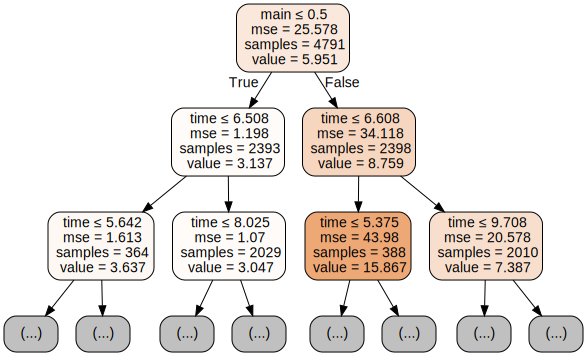

In [58]:
from sklearn.tree import DecisionTreeRegressor,export_graphviz
import graphviz
#Create a list of possible features and prepare the data for modelling.
feature_list = ['time','main']
X = SD[feature_list]
y = np.array(SD[['Avg']])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)


dt = DecisionTreeRegressor()
dt = dt.fit(X_train, y_train)
baseline = dt.score(X_test,y_test)

##Grid search
parameters = {'criterion':['mse', 'friedman_mse', 'mae'], 
              'max_depth': [1,2,3,4,5,6,7,8,9,10]}
dt = DecisionTreeRegressor()
dtGrid = GridSearchCV(dt, parameters, cv=10,n_jobs = -1)
dtGrid.fit(X_train, np.ravel(y_train))

dtBE = dtGrid.best_estimator_
dtBE.fit(X_train, np.ravel(y_train))

best = dtBE.score(X_test, y_test)
final = dtBE.score(holdout[feature_list], holdout['Avg'])

print(dtGrid.best_params_)
print('Baseline: ', round(baseline,5)," Best: ", round(best,5)," Holdout: ", round(final,5)   )


dot_data = export_graphviz(dtBE, out_file=None, 
                     feature_names=X.columns.values,  
                     filled=True, rounded=True,  
                  special_characters=True,max_depth = 2)  
graph = graphviz.Source(dot_data)  
graph 

### Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
#Create a list of possible features and prepare the data for modelling.
feature_list = ['time','main']
X = SD[feature_list]
y = np.array(SD[['Avg']])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

rf = RandomForestRegressor()

rf.fit(X_train, np.ravel(y_train))

baseline = rf.score(X_test,y_test)

##Grid search
parameters = {'n_estimators': [200,300,400,500],'max_features': [1,2], 
              'max_depth': [i for i in range(1,15)]}

rfGrid = GridSearchCV(rf, parameters, cv=3,n_jobs = -1)
rfGrid.fit(X_train, np.ravel(y_train))

rfBE = rfGrid.best_estimator_
rfBE.fit(X_train, np.ravel(y_train))

best = rfBE.score(X_test, y_test)
final = rfBE.score(holdout[feature_list], holdout['Avg'])

print(rfGrid.best_params_)
print('Baseline: ', round(baseline,5)," Best: ", round(best,5)," Holdout: ", round(final,5)   )

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'max_depth': 7, 'max_features': 1, 'n_estimators': 400}
Baseline:  0.48889  Best:  0.59276  Holdout:  0.57533


## Gradient Boosting

In [ ]:
%%time
from sklearn.ensemble import ensemble
from sklearn.model_selection import GridSearchCV

# Fit Base regression model
base = GradientBoostingRegressor()
base.fit(X_train, np.ravel(y_train))

##Grid search
#Search for best model and output results
parameters = {'n_estimators': [50,100,200,300,1000,10000],'learning_rate':[.3,.2,.1,.01, .001,.0001]}
gbr = GradientBoostingRegressor(random_state = 0)
gbrGrid = GridSearchCV(gbr, parameters, cv=5,n_jobs = -1)
gbrGrid.fit(X_train, np.ravel(y_train))



gbrBE = gbrGrid.best_estimator_

gbrBE.fit(X_train, np.ravel(y_train))
mse = mean_squared_error(y_test, gbrBE.predict(X_test))

##output
print("Base R2:",base.score(X_test,y_test))
print(gbrGrid.best_params_)
print("Base R2:",gbrBE.score(X_test,y_test))

In [ ]:
holdout['gbrBE_Resid'] = gbrBE.predict(XHold)-holdout['Avg']
holdout['gbr_Resid'] = base.predict(XHold)-holdout['Avg']

print(np.mean(np.where(holdout['gbrBE_Resid'] <=3,1,0)))
print(np.mean(np.where(holdout['gbr_Resid'] <=3,1,0)))


#### Random Grid Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [1000, 5000, 10000] #[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [1,2,3,4,5]
# Maximum number of levels in tree
max_depth = [1,2,3,4,5,6,7,8,9,10]
# Minimum number of samples required to split a node
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}



# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, 
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)


best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features

important_indices = [feature_list.index('time')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]


# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

